In [1]:
import shutil

import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensordict import MemoryMappedTensor
from torch.optim import AdamW

from world_machine_experiments.toy1d.base import toy1d_model_training_info
from world_machine_experiments.toy1d.base  import toy1d_metrics, toy1d_metrics_sample_logits, toy1d_metrics_sample_plots, save_toy1d_metrics_sample_plots
from world_machine.layers.attention import MultiHeadSelfAttention, MultiHeadAttention
from world_machine import WorldMachine
from world_machine_experiments.toy1d import Dimensions
from world_machine.train.stages  import TrainStage
from world_machine.train.scheduler import UniformScheduler
from world_machine.train import Trainer
from world_machine.train.stages import SensorialMasker, StateManager, LossManager

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

In [4]:
batch_size = 32

In [5]:
from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base
from hamilton import driver


d = driver.Builder().with_modules(base, shared).build()

inputs = {"sequence_length": 1000,
                       "n_sequence": 10000,
                       "context_size": 200,
                       "batch_size": batch_size,
                       "learning_rate": 5e-4,
                       "weight_decay": 5e-5,
                       "accumulation_steps": 1,
                       "state_dimensions": [0],
                       "device": device,
                       "state_control": "periodic",
                       "seed":[0,42],
                       "train_mse":True,
                       "train_sdtw":False,
                       "sensorial_train_losses": [Dimensions.MEASUREMENT]
                       }

outputs = d.execute(["toy1d_dataloaders", "toy1d_criterion_set"], inputs=inputs)

KeyboardInterrupt: 

In [ ]:
criterion_set = outputs["toy1d_criterion_set"]

In [ ]:
seq_len = 200
state_size = 128


In [ ]:
from world_machine.train.stages import StateManager, PrepareModel
from world_machine.train import DatasetPassMode

sm = StateManager()
pm = PrepareModel()

np_generator = np.random.default_rng(0)
torch_generator = torch.Generator(device=device)
torch_generator.manual_seed(0)

for stage in [sm, pm]:
    stage.set_generators(np_generator, torch_generator)

In [ ]:
train_loader = outputs["toy1d_dataloaders"]["train"]
val_loader = outputs["toy1d_dataloaders"]["val"]

In [ ]:
recompute = False

if recompute:

    pm.pre_batch(model, DatasetPassMode.MODE_EVALUATE, None, None, None, None, None)

    for split in ["train", "val"]:
        dataloader = outputs["toy1d_dataloaders"][split]
        dataset = dataloader.dataset
        for item in tqdm.tqdm(dataloader, desc="State Generation"):
            item = item.to(device)
            
            segments = [item]
            sm.pre_segment(segments, None, batch_size, seq_len, 0, device, state_size, None)

            sensorial_data = item["inputs"]
            state = item["inputs"]["state"]
            logits = model.inference(state=state, sensorial_data=sensorial_data)

            #logits.batch_size = [32]
            item["logits"] = logits

            segments = [item]
            sm.post_segment(segments, None, dataset, 0, None, DatasetPassMode.MODE_EVALUATE, device, None)

    pm.post_batch(model, None, None, None)

else:
    states_shape = [batch_size, seq_len, state_size]

    shutil.copyfile("TempStates_Toy1dDataset_0.bin", "TempStates_Toy1dDataset_0_copy.bin")
    shutil.copyfile("TempStates_Toy1dDataset_1.bin", "TempStates_Toy1dDataset_1_copy.bin")

    states_shape[0] = train_loader.dataset._size
    train_loader.dataset._states = MemoryMappedTensor.from_filename("TempStates_Toy1dDataset_0_copy.bin", dtype=torch.float32, shape=states_shape)

    states_shape[0] = val_loader.dataset._size
    val_loader.dataset._states = MemoryMappedTensor.from_filename("TempStates_Toy1dDataset_1_copy.bin", dtype=torch.float32, shape=states_shape)

train_loader.dataset.persist_states = True
val_loader.dataset.persist_states = True

In [ ]:
dataloaders =  outputs["toy1d_dataloaders"]

In [ ]:
model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

item = next(iter(train_loader))

item = item.to(device)

with torch.no_grad():
    logits = model(item["inputs"]["state"], sensorial_data=item["inputs"])

index = 0
plt.plot(logits["state_decoded"][index,:,0].cpu())
plt.plot(item["inputs"]["state_decoded"][index,:,0].cpu())

In [ ]:
from world_machine.train.stages import StateManager, LocalSetter, StateSaveMethod


In [ ]:
from tensordict import TensorDict
from torch.nn import Module

from world_machine import WorldMachine
from world_machine.train.stages import TrainStage
from world_machine.evaluate import MetricsGenerator
from world_machine.train import CriterionSet

class MetricsForward(TrainStage):
    def __init__(self):
        super().__init__(0)

        self._metrics_generator = MetricsGenerator(CriterionSet())

        self._dim_names = []

    def pre_train(self, model: WorldMachine, 
                  criterions: dict[str, dict[str, Module]],  
                  train_criterions: dict[str, dict[str, float]],
                  device: torch.device) -> None:
        
        self._dim_names = []

        dimensions = list(criterions.keys())
        
        for dimension in dimensions:
            for task in ["use_state", "prediction", "prediction_shallow", "prediction_local"]:
                task_dim_name = f"{task}_{dimension}"
                self._dim_names.append(task_dim_name)

                criterions[task_dim_name] = {}
                train_criterions[task_dim_name] = {}

                for criterion in criterions[dimension].keys():
                    criterions[task_dim_name][criterion] = criterions[dimension][criterion]
                    
                    if criterion in train_criterions[dimension]:
                        train_criterions[task_dim_name][criterion] = train_criterions[dimension][criterion]
                    

    def forward(self, model: WorldMachine, segment: TensorDict, mode: DatasetPassMode) -> None:
        with_gradient = mode == DatasetPassMode.MODE_TRAIN
        _, logits = self._metrics_generator(model, [segment], return_logits=True, with_gradient=)

        del logits["normal"]

        seq_len = segment["inputs"][next(iter(segment["inputs"].keys()))].shape[1]
        half_seq_len = seq_len//2

        segment.batch_size = segment.batch_size[:1]
        segment["targets"].batch_size = segment["targets"].batch_size[:1]

        segment_logits = {}
        for task in logits.keys():
            for dimension in logits[task].keys():
                segment_logits[f"{task}_{dimension}"] = logits[task][dimension]

                if dimension in segment["targets"]:
                    if task in ["use_state"]:
                        segment["targets"][f"{task}_{dimension}"] = segment["targets"][dimension][:, :half_seq_len]
                    elif task in ["prediction", "prediction_shallow"]:
                        segment["targets"][f"{task}_{dimension}"] = segment["targets"][dimension][:, half_seq_len:]
                    else:
                        segment["targets"][f"{task}_{dimension}"] = segment["targets"][dimension]
        

        segment["logits"] = segment_logits

        sensorial_masks = None
        if "input_masks" in segment:
            sensorial_masks = segment["input_masks"]
        state = segment["inputs"]["state"]
        sensorial_data = segment["inputs"]
        
        logits: TensorDict = model(state=state, sensorial_data=sensorial_data, sensorial_masks=sensorial_masks)

        for dimension in logits.keys():
            segment["logits"][dimension] = logits[dimension]

    def post_train(self, 
                   model: WorldMachine, 
                   criterions: dict[str, dict[str, Module]], 
                   train_criterions: dict[str, dict[str, float]]) -> None:

        for dim in self._dim_names:
            del criterions[dim]
            del train_criterions[dim]



In [ ]:



model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

n_epoch = 1#20

optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=5e-7)

model.to(device)

stages = []

#stages.append(SensorialMasker(UniformScheduler(0, 1, n_epoch)))
#stages.append(StateManager())
stages.append(LossManager(multiply_target_masks=False))
#stages.append(LocalSetter(0.25))
stages.append(MetricsForward())

trainer = Trainer(criterion_set, stages, seed=0)

history = trainer(model, dataloaders, optimizer, n_epoch)

In [ ]:
plt.plot(history["optimizer_loss_train"], "o-")
plt.plot(history["optimizer_loss_val"], "o-")

plt.yscale("log")

plt.show()

In [ ]:

sample_logits = toy1d_metrics_sample_logits(model, dataloaders, criterion_set)


In [ ]:
sample_plots = toy1d_metrics_sample_plots(sample_logits, skip_names=["state", "state_input", "state_control", "measurement"])

In [ ]:
metrics = toy1d_metrics(model, dataloaders, criterion_set)

In [28]:
#from world_machine_experiments.shared.save_metrics import load_multiple_metrics
#orig_metrics = load_multiple_metrics("toy1d_experiments/toy1d_experiment1_configuration_test", "toy1d_metrics")
#orig_metrics_var = orig_metrics["variation169039990650476837415612865146336274566"]

orig_metrics_var = {'means': {'normal': {'state_decoded_mse': 0.005745531525462866,
   'state_decoded_0.1sdtw': 0.049730513244867325,
   'measurement_mse': 0.0031138439662754536,
   'measurement_0.1sdtw': 0.03741569444537163,
   'optimizer_loss': 0.004429687280207872},
  'use_state': {'state_decoded_mse': 0.009278137236833572,
   'state_decoded_0.1sdtw': 0.04497543349862099,
   'measurement_mse': 0.005326921585947275,
   'measurement_0.1sdtw': 0.03941391780972481,
   'optimizer_loss': 0.00730252917855978},
  'prediction': {'state_decoded_mse': 0.038888320326805115,
   'state_decoded_0.1sdtw': 0.14090374112129211,
   'measurement_mse': 0.02607259713113308,
   'measurement_0.1sdtw': 0.17161616683006287,
   'optimizer_loss': 0.03248045966029167},
  'prediction_shallow': {'state_decoded_mse': 0.18497686088085175,
   'state_decoded_0.1sdtw': 1.0416010618209839,
   'measurement_mse': 0.1196795180439949,
   'measurement_0.1sdtw': 1.309909701347351,
   'optimizer_loss': 0.15232817828655243}},
 'stds': {'normal': {'state_decoded_mse': 0.0,
   'state_decoded_0.1sdtw': 0.0,
   'measurement_mse': 0.0,
   'measurement_0.1sdtw': 0.0,
   'optimizer_loss': 0.0},
  'use_state': {'state_decoded_mse': 0.0,
   'state_decoded_0.1sdtw': 0.0,
   'measurement_mse': 0.0,
   'measurement_0.1sdtw': 0.0,
   'optimizer_loss': 0.0},
  'prediction': {'state_decoded_mse': 0.0,
   'state_decoded_0.1sdtw': 0.0,
   'measurement_mse': 0.0,
   'measurement_0.1sdtw': 0.0,
   'optimizer_loss': 0.0},
  'prediction_shallow': {'state_decoded_mse': 0.0,
   'state_decoded_0.1sdtw': 0.0,
   'measurement_mse': 0.0,
   'measurement_0.1sdtw': 0.0,
   'optimizer_loss': 0.0}}}

In [32]:
#from world_machine_experiments.shared.save_metrics import load_multiple_metrics
#orig_metrics = load_multiple_metrics("toy1d_experiments/toy1d_experiment1_configuration_test", "toy1d_metrics")
#orig_metrics_var = orig_metrics["variation169039990650476837415612865146336274566"]

orig_metrics_var = {"means":{'normal': {'state_decoded_mse': 0.005745531525462866,
   'state_decoded_0.1sdtw': 0.049730513244867325,
   'measurement_mse': 0.0031138439662754536,
   'measurement_0.1sdtw': 0.03741569444537163,
   'optimizer_loss': 0.004429687280207872},
  'use_state': {'state_decoded_mse': 0.009278137236833572,
   'state_decoded_0.1sdtw': 0.04497543349862099,
   'measurement_mse': 0.005326921585947275,
   'measurement_0.1sdtw': 0.03941391780972481,
   'optimizer_loss': 0.00730252917855978},
  'prediction': {'state_decoded_mse': 0.038888320326805115,
   'state_decoded_0.1sdtw': 0.14090374112129211,
   'measurement_mse': 0.02607259713113308,
   'measurement_0.1sdtw': 0.17161616683006287,
   'optimizer_loss': 0.03248045966029167},
  'prediction_shallow': {'state_decoded_mse': 0.18497686088085175,
   'state_decoded_0.1sdtw': 1.0416010618209839,
   'measurement_mse': 0.1196795180439949,
   'measurement_0.1sdtw': 1.309909701347351,
   'optimizer_loss': 0.15232817828655243},
 'prediction_local': {'state_decoded_mse': 0.012613601982593536,
  'measurement_mse': 0.007521921303123236,
  'optimizer_loss': 0.010067763738334179}}}

full_local_train_metrics = {'normal': {'state_decoded_mse': 0.0049809119664132595,
  'measurement_mse': 0.0026522234547883272,
  'optimizer_loss': 0.0038165689911693335},
 'use_state': {'state_decoded_mse': 0.009360411204397678,
  'measurement_mse': 0.005486011505126953,
  'optimizer_loss': 0.007423209026455879},
 'prediction': {'state_decoded_mse': 0.03635825589299202,
  'measurement_mse': 0.023967953398823738,
  'optimizer_loss': 0.030163107439875603},
 'prediction_shallow': {'state_decoded_mse': 0.10081760585308075,
  'measurement_mse': 0.06785740703344345,
  'optimizer_loss': 0.08433755487203598},
 'prediction_local': {'state_decoded_mse': 0.00782993994653225,
  'measurement_mse': 0.004544243682175875,
  'optimizer_loss': 0.00618709297850728}}

full_local_FIXED_train_metrics = {
    "normal": {
        "state_decoded_mse": 0.004724666941910982,
        "measurement_mse": 0.0025153954047709703,
        "optimizer_loss": 0.003620031289756298
    },
    "use_state": {
        "state_decoded_mse": 0.008553487248718739,
        "measurement_mse": 0.004893651697784662,
        "optimizer_loss": 0.006723570171743631
    },
    "prediction": {
        "state_decoded_mse": 0.038927361369132996,
        "measurement_mse": 0.026426397264003754,
        "optimizer_loss": 0.03267688676714897
    },
    "prediction_shallow": {
        "state_decoded_mse": 0.1186642050743103,
        "measurement_mse": 0.0776614099740982,
        "optimizer_loss": 0.09816279262304306
    },
    "prediction_local": {
        "state_decoded_mse": 0.007323125842958689,
        "measurement_mse": 0.004273825325071812,
        "optimizer_loss": 0.005798475816845894
    }
}

In [34]:
metrics = full_local_train_metrics

In [35]:
for task in ["normal", "use_state", "prediction", "prediction_shallow", "prediction_local"]:
    m_task = metrics[task]["state_decoded_mse"]
    m_task_orig = orig_metrics_var["means"][task]["state_decoded_mse"]
    diff = (m_task-m_task_orig)/m_task_orig
    
    print(task, metrics[task]["state_decoded_mse"], orig_metrics_var["means"][task]["state_decoded_mse"], 100*diff, sep="|")

normal|0.0049809119664132595|0.005745531525462866|-13.308073511754124
use_state|0.009360411204397678|0.009278137236833572|0.8867509227766533
prediction|0.03635825589299202|0.038888320326805115|-6.5059750911102245
prediction_shallow|0.10081760585308075|0.18497686088085175|-45.49717982401058
prediction_local|0.00782993994653225|0.012613601982593536|-37.92463122478911


** FULL TRAIN - 25% Local Synched **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.0049809119664132595|0.005745531525462866|-13.308073511754124
use_state|0.009360411204397678|0.009278137236833572|0.8867509227766533
prediction|0.03635825589299202|0.038888320326805115|-6.5059750911102245
prediction_shallow|0.10081760585308075|0.18497686088085175|-45.49717982401058
prediction_local|0.00782993994653225|0.012613601982593536|-37.92463122478911

** FULL TRAIN - 25% Local Synched - STR FIXED**
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.004724666941910982|0.005745531525462866|-17.767974625631208
use_state|0.008553487248718739|0.009278137236833572|-7.810296071478903
prediction|0.038927361369132996|0.038888320326805115|0.10039271945867634
prediction_shallow|0.1186642050743103|0.18497686088085175|-35.849162695681756
prediction_local|0.007323125842958689|0.012613601982593536|-41.9426278626484

** Free State - 25% Local Synched - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.0050505707040429115|0.005745531525462866|-12.095675018752377
use_state|0.008438738994300365|0.009278137236833572|-9.047055687006365
prediction|0.054429881274700165|0.038888320326805115|39.964598155149666
prediction_shallow|0.1292940080165863|0.18497686088085175|-30.10260450907542

** Free State - 25% Local Synched - Free Attention - MEAN State Save **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.005373441614210606|0.005745531525462866|-6.476161685011106
use_state|0.0094678970053792|0.009278137236833572|2.0452356297586785
prediction|0.061995361000299454|0.038888320326805115|59.41897330434972
prediction_shallow|0.1695307046175003|0.18497686088085175|-8.350318082919948

** Free State - 25% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.005358148366212845|0.005745531525462866|-6.742338067996467
use_state|0.008892103098332882|0.009278137236833572|-4.1606857998194
prediction|0.0572088360786438|0.038888320326805115|47.11058641226692
prediction_shallow|0.12881498038768768|0.18497686088085175|-30.361570753078865

** Free State - 12,5% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.0049077654257416725|0.005745531525462866|-14.581176624101841
use_state|0.008334457874298096|0.009278137236833572|-10.171000260581769
prediction|0.044793665409088135|0.038888320326805115|15.185395081753011
prediction_shallow|0.14026586711406708|0.18497686088085175|-24.171127974533064



** Free State - 75% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.008892265148460865|0.005745531525462866|54.76836405913716
use_state|0.013661500066518784|0.009278137236833572|47.243996481142354
prediction|0.1157604530453682|0.038888320326805115|197.67408844751856
prediction_shallow|0.13783054053783417|0.18497686088085175|-25.487685388598795


** Free State - 50% Local - Free Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.00673825666308403|0.005745531525462866|17.278212350269705
use_state|0.011048161424696445|0.009278137236833572|19.07736588370344
prediction|0.07129403948783875|0.038888320326805115|83.3302104300372
prediction_shallow|0.13433396816253662|0.18497686088085175|-27.377960939090368


** Free State - 50% Local - Free Attention - Normal LR+WD**
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.007665029726922512|0.005745531525462866|33.408540062009486
use_state|0.01167269703000784|0.009278137236833572|25.80862658150849
prediction|0.10275819897651672|0.038888320326805115|164.23923201868683
prediction_shallow|0.16969460248947144|0.18497686088085175|-8.261713556283128


** Free State - 50% Local - Free Attention - State Check Local**
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.00942055881023407|0.005745531525462866|63.96322548199994
use_state|0.015547704882919788|0.009278137236833572|67.57356014520307
prediction|0.1238749548792839|0.038888320326805115|218.5402553730222
prediction_shallow|0.14469878375530243|0.18497686088085175|-21.774657075348163



** Free State - 50% Local - Freeze Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.008472094312310219|0.005745531525462866|47.45536204551063
use_state|0.017644142732024193|0.009278137236833572|90.16902080277654
prediction|0.10345781594514847|0.038888320326805115|166.0382733831695
prediction_shallow|0.13891147077083588|0.18497686088085175|-24.903325686604525

** Fixed State - Always Local - Freeze Attention **
Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.027041437104344368|0.005745531525462866|370.65161829680994
use_state|0.024210166186094284|0.009278137236833572|160.9377892146451
prediction|0.1684352308511734|0.038888320326805115|333.12549741335476
prediction_shallow|0.1637730598449707|0.18497686088085175|-11.46294781677528

In [ ]:
plt.plot(sample_logits["normal"]["state"][0])

plt.show()

In [ ]:
plt.plot((torch.abs(sample_logits["normal"]["state"][0])>0.9).sum(1)/128)

plt.ylim(0,1)

## Metrics Post Train

In [ ]:
from world_machine.evaluate import MetricsGenerator

In [ ]:
mg = MetricsGenerator(criterion_set)

In [ ]:
item = next(iter(val_loader))

In [ ]:
model : WorldMachine = torch.load("local_test\\local_0\\run_0\\toy1d_model.pt", weights_only=False, map_location=device)

In [ ]:
metrics = mg(model, val_loader)

In [ ]:
metrics

In [ ]:
metrics["prediction_shallow"]["state_decoded_mse"]/metrics["prediction_local"]["state_decoded_mse"]

In [ ]:
orig_metrics_var["means"]["prediction_shallow"]["state_decoded_mse"]/orig_metrics_var["means"]["prediction_local"]["state_decoded_mse"]

Metrics Generation: 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


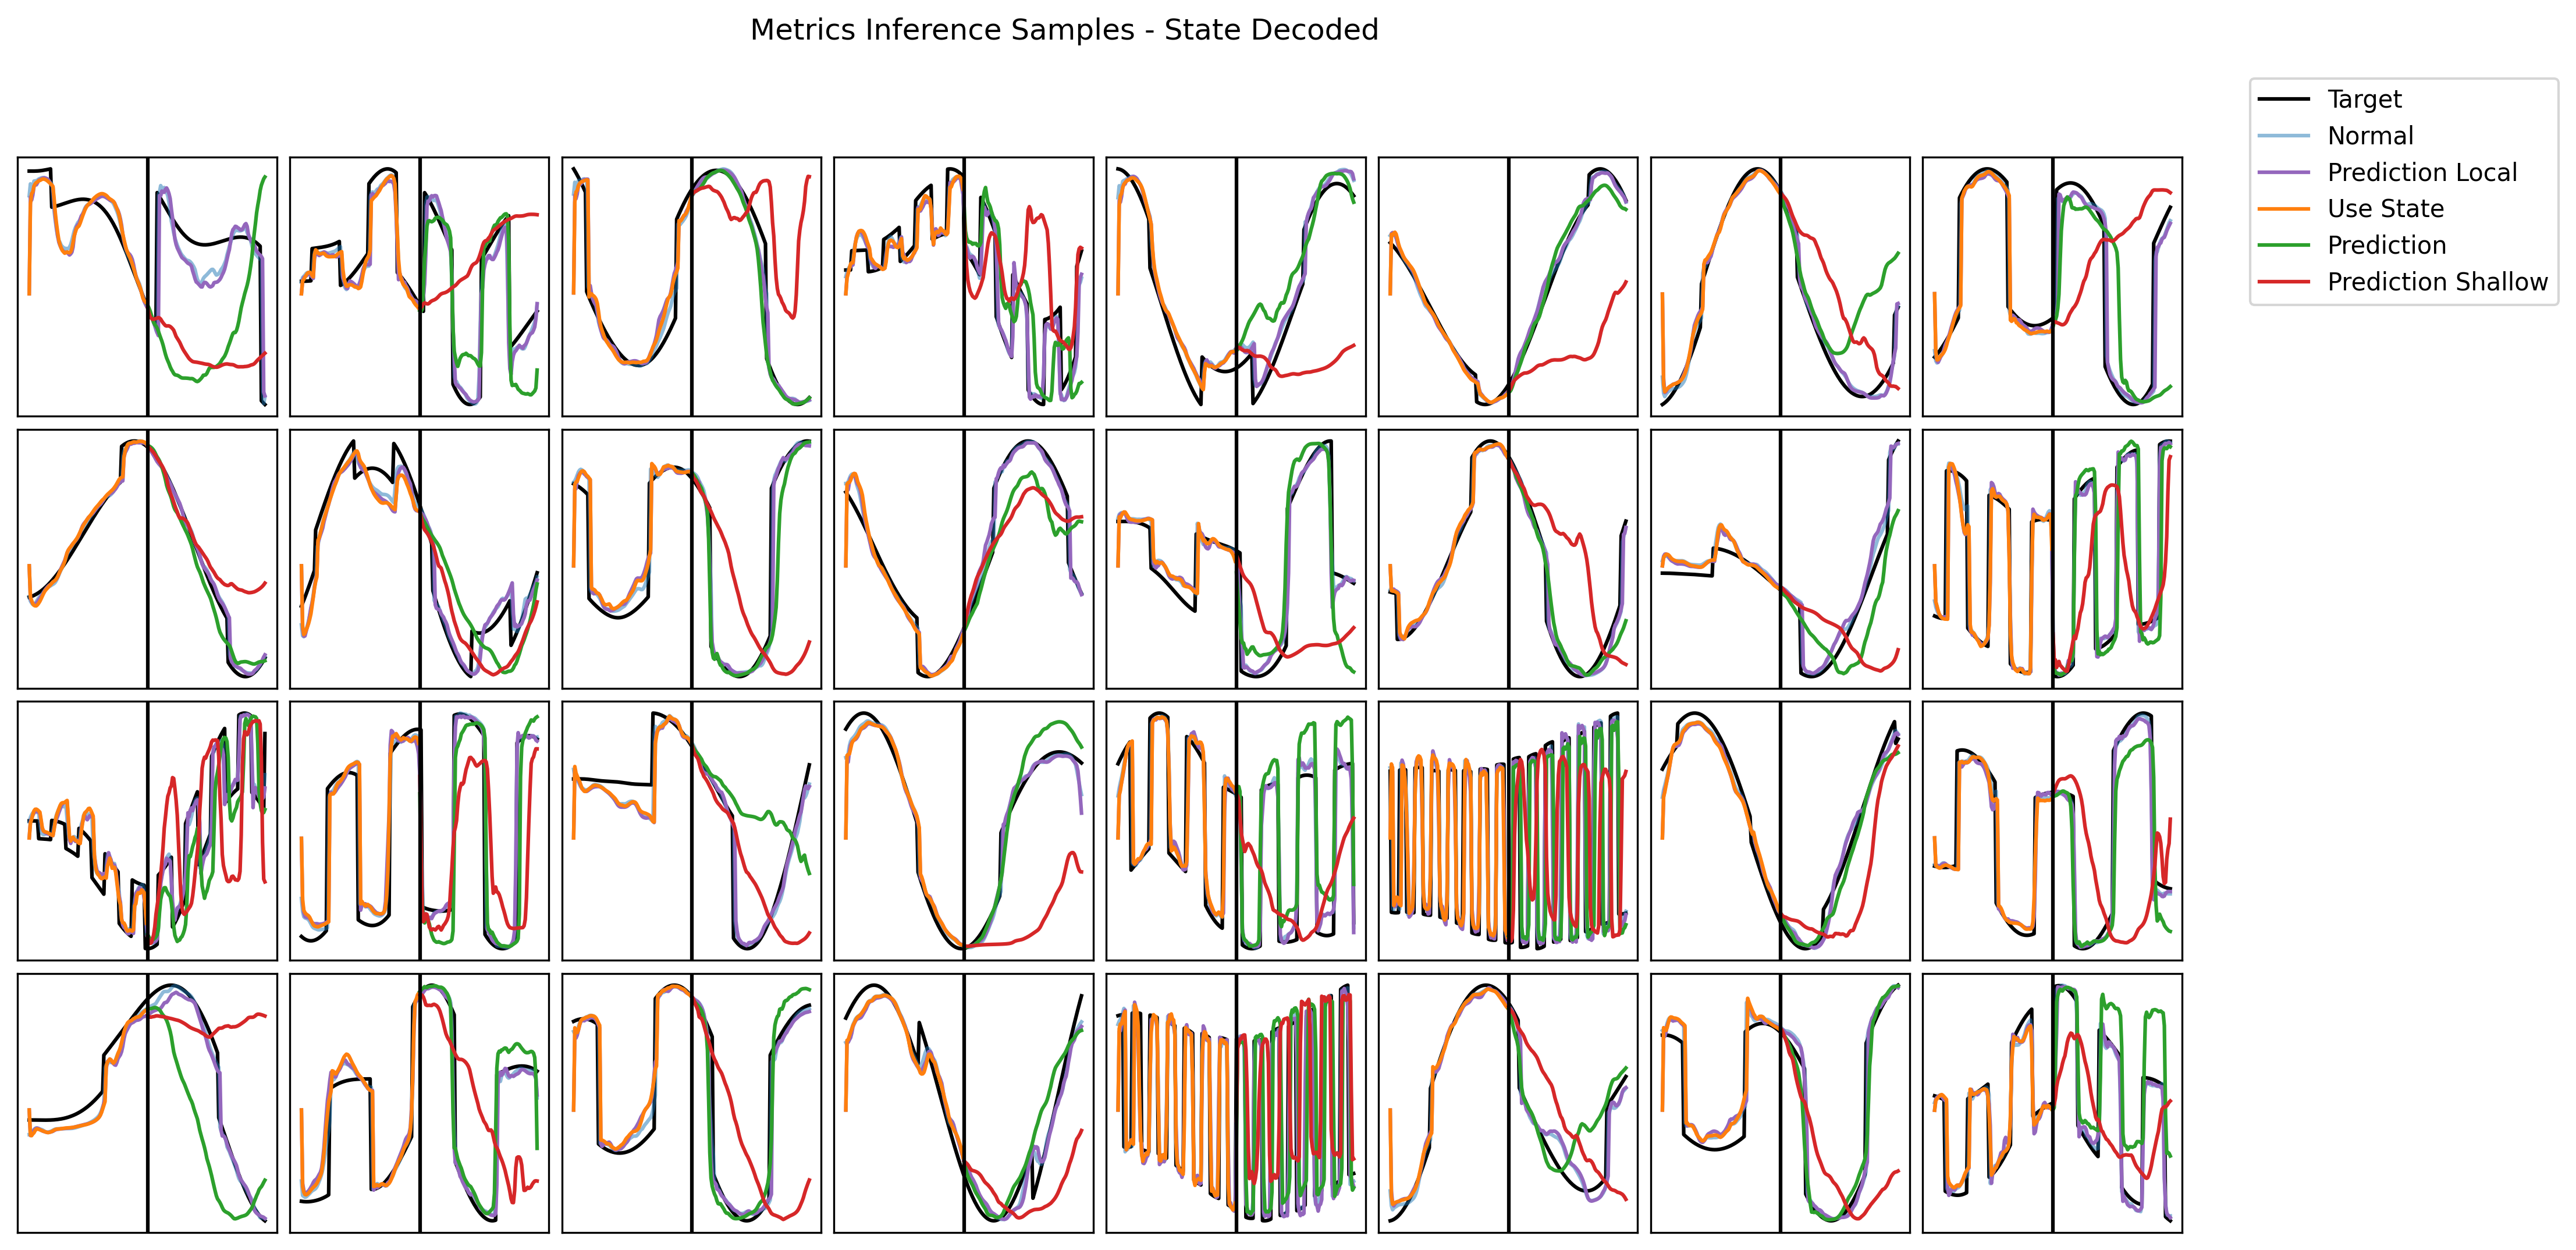

In [19]:
model : WorldMachine = torch.load("local_test\\local_2_FIX_STR\\run_0\\toy1d_model.pt", weights_only=False, map_location=device)
sample_logits = toy1d_metrics_sample_logits(model, dataloaders, criterion_set)
sample_plots = toy1d_metrics_sample_plots(sample_logits, skip_names=["state", "state_input", "state_control", "measurement"])